In [2]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import CfC
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

data_x.shape:  torch.Size([1, 48, 2])
data_y.shape:  torch.Size([1, 48, 1])
tensor([0.1992, 0.9800])
tensor([0.3904])
1


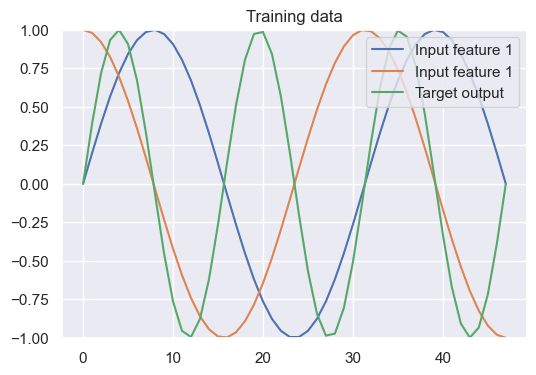

In [3]:
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
 # x is input, y is expected output. No x axis baked in, assumes linear time series
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))
print(data_x[0,1])
print(data_y[0,1])
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4 # Based on these input values, what expected output value?
)
print(dataloader.batch_size)
# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [4]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [ ]:
out_features = 1
in_features = 2

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    accelerator='gpu'
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


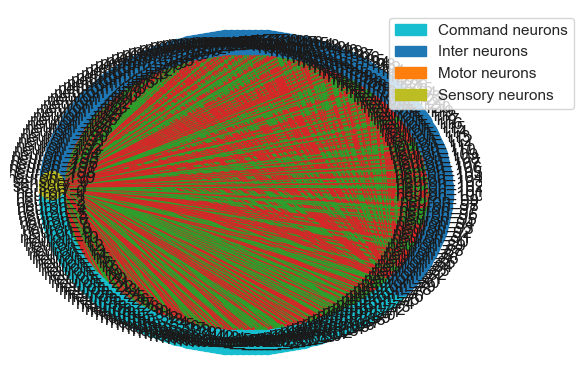

In [9]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

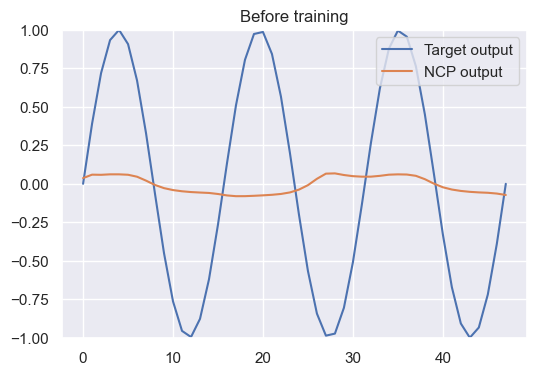

In [10]:
# Let's visualize how LTC initialy performs before the training
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [6]:
# Train the model for 400 epochs (= training steps)
trainer.fit(learn, dataloader)

c:\Users\will\miniconda3\envs\Kettering\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 2.3 K  | train
---------------------------------------
1.8 K     Trainable params
440       Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
c:\Users\will\miniconda3\envs\Kettering\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\will\miniconda3\envs\Kettering\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=17, train_loss=0.483]        

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000224B25228E0>
Traceback (most recent call last):
  File "c:\Users\will\miniconda3\envs\Kettering\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\will\miniconda3\envs\Kettering\Lib\site-packages\torch\utils\data\dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\will\miniconda3\envs\Kettering\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\Users\will\miniconda3\envs\Kettering\Lib\multiprocessing\popen_spawn_win32.py", line 114, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


Epoch 399: 100%|██████████| 1/1 [00:03<00:00,  0.27it/s, v_num=17, train_loss=8.33e-5] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 1/1 [00:03<00:00,  0.27it/s, v_num=17, train_loss=8.33e-5]


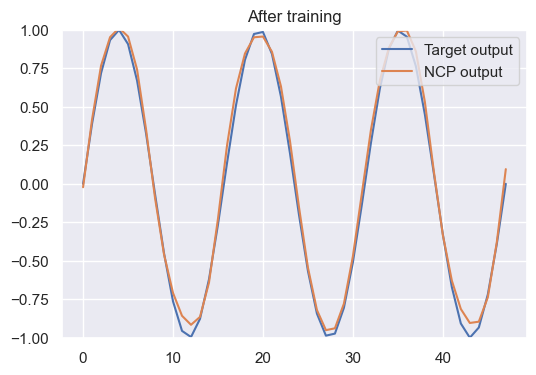

In [22]:
# How does the trained model now fit to the sinusoidal function?
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()